# Pregunta 4

### Funciones de activación

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def softmax_prime(x):
    upper = np.exp(-x)
    down = np.power(1 + np.exp(-x), 2)
    return upper / down

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

def relu(x):
    return np.abs(x) * (x > 0)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def linear(x):
    return x

### Dataset

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Convert the targets to one hot vectors
import keras
y_onehot = keras.utils.to_categorical(y_train)

### Red Feed-forward con momentum

In [ ]:
import numpy as np
from random import randint, random, seed, uniform
import keras
    
class Network:
    # The layers variable receives a specification with the following format:
    # [
    #    "neurons": n_neurones,
    #    "activation": "activation_function",
    # ]
    
    activation_function_hash = {
        "softmax": {
            "func": softmax,
            "func_prime": softmax_prime,
        },
        "sigmoid": {
            "func": sigmoid,
            "func_prime": sigmoid_prime,
        },
        
        "relu": {
            "func": relu,
            "func_prime": relu_prime,
        },
        
        "linear": {
            "func": linear,
            "func_prime": 1,
        }
    }
    
    # loss defines the method to calculate cost
    # crossentropy or mse
    def __init__(self, layers, loss="mse", mu = 1.0):
        self.layers = layers
        self.loss = loss
        self.loss_history = []
        self.mu = mu
        
        # The first layer is the input layer, and does not have biases
        # or weights
        self.biases = np.array([np.random.randn(l["neurons"], 1) for l in layers[1:]])
        
        # The amount of weights depensd on both the amount of neurones on the layer 
        # and the dimension of the inputs.
        self.weights = [np.random.randn(curr_l["neurons"], prev_l["neurons"]) for prev_l, curr_l in zip(layers[:-1], layers[1:])]
        self.velocities = [np.zeros((curr_l["neurons"], prev_l["neurons"])) for prev_l, curr_l in zip(layers[:-1], layers[1:])]

    # Returns final output, activation output at each layer
    # and z value at each layer
    def forward_propagation(self, data):
        output = data
        activations = [data.reshape(len(data), 1)]
        zs = []
        
        # We start on the first layer. Note that the input layer
        # is pretty much ignored as it does not have activation
        # functions or anything like that.
        for B, W, layer, index in zip(self.biases, self.weights, self.layers, range(0, len(self.biases))):
            dot = np.dot(W, output)
            dot = dot.reshape(len(dot), 1)
            Z = dot + B

            zs.append(Z)
            activation_string = layer["activation"]
            g = Network.activation_function_hash[activation_string]["func"]
            output = g(Z)
            
            
            
            activations.append(output)

        return activations, zs    
    
    
    # Devuelve el output de la red
    def evaluate(self, X):
        output = []
        for x in X:
            (acts, zs) = self.forward_propagation(x)
            output.append(self.classify(acts[len(self.biases)]))
            
        return np.array(output)
    
    def classify(self, x):
        chosen_class = 2 ** np.argmax(x)
        total_classes = self.layers[-1]["neurons"]
        return (((chosen_class & (1 << np.arange(total_classes)))) > 0).astype(int)
        
        
        
    
    # Receives a single sample X with its 
    # corresponding value Y and returns the 
    # derivatives for the weights and biases
    # We want to get dc/db and dc/dw
    
    def get_total_cost(self, X, Y):
        
        n = self.layers[-1]["neurons"]
        
        cost = 0.0
        A = self.evaluate(X)
        
        
        if self.loss == "mse":
            for a, y in zip(A, Y):
                cost += 0.5*np.linalg.norm(a.reshape(n, 1) - np.array(y).reshape(n, 1))**2 / len(A)
            return cost
        elif self.loss == "crossentropy":
            for a, y in zip(A, Y):
                a = a.reshape(n, 1)
                y = np.array(y.reshape(n, 1))
                cost += np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a))) / len(A)
        return cost
    def get_delta(self, a, z, y, activation_derivative):
        # Equation 1 says how this should got, at least for mse
        if self.loss == "mse":
            return (a - y) * activation_derivative(z)
        elif self.loss == "crossentropy":
            return (a - y)
        
        return None
    
    def backprop(self, x, y):
        
        
        # Initialize the gradient
        gradient_b = np.array([np.zeros(bias.shape) for bias in self.biases])
        gradient_w = np.array([np.zeros(weight.shape) for weight in self.weights])
        
        # Propagate the input through the network and get all the
        # z outputs and activation outputs of all layers
        # The first activation corresponds to the first input layer
        (acts, zs)  = self.forward_propagation(x)
        
        # Use the specified activation function's derivative
        activation_derivative = Network.activation_function_hash[self.layers[-1]["activation"]]["func_prime"]
        
        # We first calculate the delta value of the output layer, given as
        # delta_cost = aL - y
        # [ , , , , X] (= -1)
        # [ , , , X, ] ( = -2)
        # ....
        # [X, , , , ,] ( = -L)
        
        yHat = np.array(self.classify(acts[-1]))

        delta = self.get_delta(yHat.reshape(3, 1), zs[-1], y.reshape(3, 1), activation_derivative)
        
        # 
        # Gradient B = delta
        gradient_b[-1] = delta
        
        # Gradient W = delta x A(L - 1)T
        gradient_w[-1] = np.dot(delta, acts[-2].T)
        
        # We now have the L layer with its deltas and gradients claculated.
        # Now we iterate over each layer to get the specific deltas
        for l in range(2, len(self.layers)):
            z = zs[-l] # The minus syntax makes the array to get the farther
            
            # Use the specified activation function's derivative
            activation_derivative = Network.activation_function_hash[self.layers[-l]["activation"]]["func_prime"]
            
            delta = np.dot(self.weights[-l + 1].T, delta) * activation_derivative(z)
            
            gradient_b[-l] = delta
            
            gradient_w[-l] = np.dot(delta, acts[-l - 1].T)
            
        return (gradient_b, gradient_w)
            
    def get_costs(self):
        return self.loss_history
        
    def SGD_momentum(self, trainX, trainY, epochs, learn_rate):
        
        change_b = np.array([np.zeros(b.shape) for b in self.biases])
        change_w = np.array([np.zeros(w.shape) for w in self.weights])
    
        for epoch in range(0, epochs):
            print("Epoch", epoch + 1)
            for X, Y in zip(trainX, trainY):

                """
                The backprop function will propagate the current information
                through the network and then calculate the gradients of
                each layer. Considering that we have a single bias per layer,
                gradient_b will be an array of size L, being L the total number
                of layers, excluding the input layer.

                gradient_w will be an array of size L too, in which each element
                becomes a vector that represents the gradient of all the weights
                of a layer.
                """
                (gradient_b, gradient_w) = self.backprop(X, Y)

                """
                Now that we have the gradients of the weights, we want to
                store this information for this particular training example in
                order to average it later on. The change_b represents the sum of
                the changes of all training examples for all biases, and change_w
                does the same for all weights.

                Later, as if we were trying to get the average of a list, we will
                divide this sum by the total amount of examples. This will tell
                us the average change of all training examples and allow us to
                modify the weights.
                """
                change_b = [(cb + gb)
                            for cb, gb in zip(change_b, gradient_b)]
                change_w = [(cw + gw)
                            for cw, gw in zip(change_w, gradient_w)]

            self.weights = [weight - (learn_rate / len(trainX)) * weight_change for weight, weight_change in zip(self.weights, change_w)]
            self.biases = [bias -(learn_rate / len(trainX))*bias_change for bias, bias_change in zip(self.biases, change_b)]  
            
            # Save the loss function on each epoch for future experiments
            self.loss_history.append(self.get_total_cost(trainX, trainY))
                
    
# The network should have 2 layers, the first with 32 neurons and the second with 16
# You basically will have an architecture like this:
# input -> layer 1 (32) -> later 2 (16) -> output (3 neurons with softmax activation function)

"""
Bellow here we test our implementation
"""
import keras
seed(10)
T = 100
M = 5
dataX = np.array([np.random.randn(M, 1) for n in range(0, T)])
dataY = [randint(0,2) for n in range(0, T)]
dataYOnehot = keras.utils.to_categorical(dataY)
network = Network([{
    "neurons": len(X_train[0]),
    "activation": "linear"
}, {
    "neurons": 32,
    "activation": "sigmoid"
}, {
    "neurons": 16,
    "activation": "sigmoid"
}, {
    "neurons": 3,
    "activation": "softmax"
}])

x = dataX[0]
y = dataY[0]


network.SGD_momentum(X_train, y_onehot, 700, 0.1)
yHat = np.array(network.evaluate(X_train))

# Measure accuracy

from sklearn.metrics import accuracy_score
print("Tests passed with a score of: ", accuracy_score(y_onehot, yHat))








Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 11

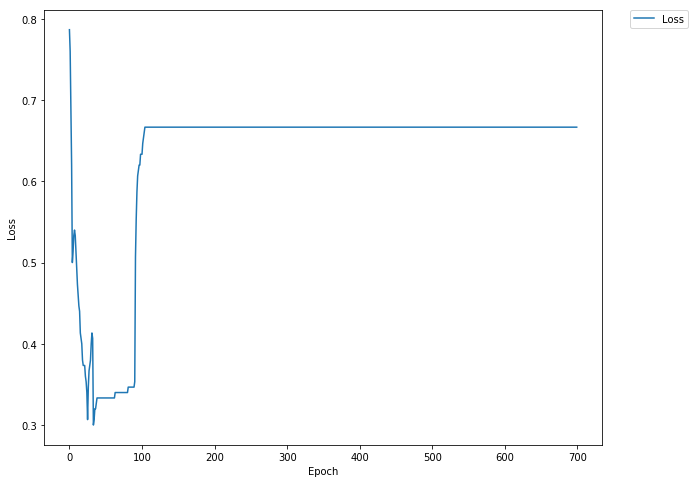

In [30]:
import matplotlib.pyplot as plt


costs = network.get_costs()
plt.figure(figsize=(10, 8))
plt.plot(range(0, len(costs)), costs, label="Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()